# SETTING UP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/MyDrive/HCMUT/ML242/BTL')

In [ ]:
if os.path.isdir('/content/drive/MyDrive/HCMUT/ML242/BTL'):
    print("OK")
else: print("NO")

OK



**Dataset structure**
```
dataset
|-- Original
|        |-- Training
|        |       |-- glioma     (Tr_gl_xxxx.jpg)    --> 1321 images
|        |       |-- meningioma (Tr_me_xxxx.jpg)    --> 1339 images
|        |       |-- notumor    (Tr_no_xxxx.jpg)    --> 1595 images
|        |       |-- pituitary  (Tr_pi_xxxx.jpg)    --> 1457 images
|        |-- Testing
|        |       |-- glioma     (Te_gl_xxxx.jpg)    --> 300 images
|        |       |-- meningioma (Te_me_xxxx.jpg)    --> 306 images
|        |       |-- notumor    (Te_no_xxxx.jpg)    --> 405 images
|        |       |-- pituitary  (Te_pi_xxxx.jpg)    --> 300 images
|-- AfterPreprocess
|        |-- Training
|        |       |-- glioma     (Tr_gl_xxxx.jpg)    --> 1321 images
|        |       |-- meningioma (Tr_me_xxxx.jpg)    --> 1339 images
|        |       |-- notumor    (Tr_no_xxxx.jpg)    --> 1595 images
|        |       |-- pituitary  (Tr_pi_xxxx.jpg)    --> 1457 images
|        |-- Testing
|        |       |-- glioma     (Te_gl_xxxx.jpg)    --> 300 images
|        |       |-- meningioma (Te_me_xxxx.jpg)    --> 306 images
|        |       |-- notumor    (Te_no_xxxx.jpg)    --> 405 images
|        |       |-- pituitary  (Te_pi_xxxx.jpg)    --> 300 images
|        |-- augmented_img_paths.json
```



# DATA LOADER

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import cv2

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self,
                 data_dir: str,
                 class_names: list,
                 transform=None,
                 mode: str = "Training"):
        self.data_dir = data_dir
        self.class_names = class_names
        self.transform = transform
        self.mode = mode
        self.img_paths = []
        self.labels = []

        for class_id, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.data_dir, self.mode, class_name)
            if not os.path.isdir(class_dir):
                raise ValueError(f"Directory not found: {class_dir}")

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith('.jpg'):
                    self.img_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_id)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to load image: {self.img_paths[idx]}")

        img = img.astype('float32') / 255.0

        img = torch.from_numpy(img).unsqueeze(0)  # shape: [1, H, W]

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

In [ ]:
class Loader:
    """
    DataLoader factory for binary classification between two classes.
    Defaults to ['notumor', 'glioma'], but can accept any two-element list.
    """
    def __init__(self,
                 data_dir: str = "dataset/AfterPreprocess",
                 batch_size: int = 32,
                 validation_split: float = 0.2,
                 class_names: list = ["notumor", "glioma"]):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.class_names = class_names

    def get_dataloader(self):
        transform = transforms.Compose([
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        full_train = BrainTumorDataset(
            data_dir=self.data_dir,
            class_names=self.class_names,
            transform=transform,
            mode="Training"
        )
        val_size = int(len(full_train) * self.validation_split)
        train_size = len(full_train) - val_size
        generator = torch.Generator().manual_seed(42)
        train_set, val_set = random_split(full_train, [train_size, val_size], generator=generator)
        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True,
                                  num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=False,
                                num_workers=2, pin_memory=True)
        test_set = BrainTumorDataset(
            data_dir=self.data_dir,
            class_names=self.class_names,
            transform=transform,
            mode="Testing"
        )
        test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=False,
                                 num_workers=2, pin_memory=True)
        return train_loader, val_loader, test_loader

# LOGISTIC REGRESSION

In [ ]:
import torch.nn as nn

In [ ]:
class VanilaLogisticRegression(nn.Module):
    """Simple CNN followed by a binary classification head"""
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # downsample by 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # downsample by 2
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(32, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)       # [B, 32, 1, 1]
        x = x.view(x.size(0), -1)     # [B, 32]
        return self.classifier(x)     # [B, 1]

# HYPERPARAMETERS

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
VAL_SPLIT = 0.2
LR = 1e-2

# TRAINING FUNCTION FOR LOGISTIC REGRESISON

In [ ]:
import torch.optim as optim
import json
import time

In [ ]:
def train(num_epochs:int = 40,
          save_history:bool = True):

    loader = Loader(data_dir="dataset/AfterPreprocess",
                    batch_size=BATCH_SIZE,
                    validation_split=0.2)
    train_loader, val_loader, test_loader = loader.get_dataloader()
    model = VanilaLogisticRegression().to(DEVICE)
    print(f'-----Running on {DEVICE}-----')
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    val_losses = []
    val_accuracies = []
    epoch_train_times = []

    print(f"----- Training -----")
    for epoch in range(num_epochs):
        print(f"-> Epoch {epoch + 1}/{num_epochs} -----")
        model.train()
        running_loss = 0.0
        t0 = time.perf_counter()
        for imgs, labels in train_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE).float().unsqueeze(1)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        t1 = time.perf_counter()
        epoch_time = t1 - t0
        epoch_train_times.append(epoch_time)
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"---Train loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE).float().unsqueeze(1)
                logits = model(imgs)
                loss = criterion(logits, labels)
                val_running_loss += loss.item() * imgs.size(0)
                preds = (torch.sigmoid(logits) > 0.5).long()
                correct += (preds.squeeze(1) == labels.long().squeeze(1)).sum().item()
                total += labels.size(0)
        avg_val_loss = val_running_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"---Val Loss: {avg_val_loss:.4f}")
        print(f"---Val Acc: {val_acc:.4f}")

    train_loss_arr = np.array(train_losses)
    val_loss_arr = np.array(val_losses)
    val_acc_arr = np.array(val_accuracies)

    history = {
        'train_loss': train_loss_arr.tolist(),
        'val_loss': val_loss_arr.tolist(),
        'val_accuracy': val_acc_arr.tolist(),
        'epoch_train_times':epoch_train_times
    }
    if save_history:
        with open('LogisticHistory.json', 'w') as f:
            json.dump(history, f)
        print(f"Save history successfully at LogisticHistory.json")

In [ ]:
train()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_loss_and_accuracy(json_path='LogisticHistory.json',
                           save_plots=True,
                           save_dir='LogisticPlots'):
    with open(json_path, 'r') as f:
        history = json.load(f)
    train_loss = np.array(history['train_loss'])
    val_loss   = np.array(history['val_loss'])
    val_acc    = np.array(history['val_accuracy'])
    epochs     = np.arange(1, len(train_loss) + 1)

    if save_plots:
        import os
        os.makedirs(save_dir, exist_ok=True)

    plt.figure()
    plt.plot(epochs, train_loss, marker='o', label='Train Loss')
    plt.plot(epochs, val_loss,   marker='o', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    if save_plots:
        plt.savefig(f'{save_dir}/Train_loss_curve.png', dpi=300)
    plt.show()

    plt.figure()
    plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    if save_plots:
        plt.savefig(f'{save_dir}/Validation_accuracy_curve.png', dpi=300)
    plt.show()

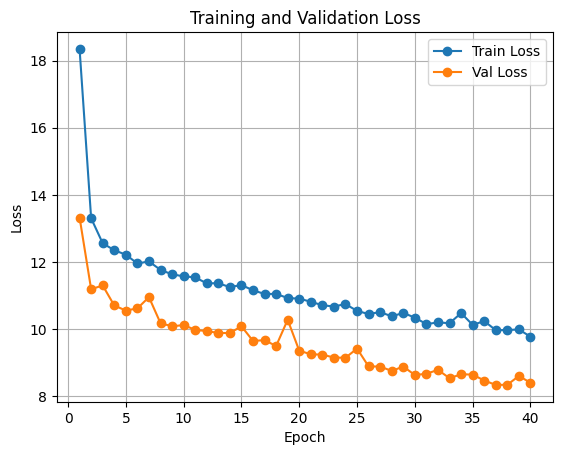

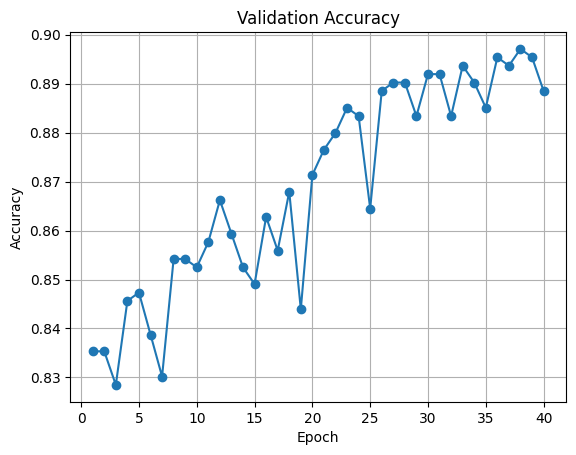

In [ ]:
plot_loss_and_accuracy()

# PCA

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset

In [ ]:
loader = Loader(
    data_dir="dataset/AfterPreprocess",
    batch_size=32,
    validation_split=0.2,
    class_names=["notumor","glioma"]
)
train_dl, val_dl, test_dl = loader.get_dataloader()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def collect_flattened(loader: DataLoader):
    X_parts, y_parts = [], []
    for imgs, labels in loader:
        B, C, H, W = imgs.shape
        flat = imgs.view(B, -1).numpy()
        X_parts.append(flat)
        y_parts.append(labels.numpy())
    return np.vstack(X_parts), np.concatenate(y_parts)

X_train, y_train = collect_flattened(train_dl)
X_val,   y_val   = collect_flattened(val_dl)
X_test,  y_test  = collect_flattened(test_dl)

In [ ]:
n_components = 512
pca = PCA(n_components=n_components, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca   = pca.transform(X_val)
X_test_pca  = pca.transform(X_test)

In [ ]:
train_ds = TensorDataset(
    torch.from_numpy(X_train_pca).float(),
    torch.from_numpy(y_train).long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val_pca).float(),
    torch.from_numpy(y_val).long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test_pca).float(),
    torch.from_numpy(y_test).long()
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

In [ ]:
class Classifier(nn.Module):
    def __init__(self,
                 input_dim: int,
                 hidden_dims: list = [256, 128],
                 n_classes: int = 2,
                 dropout: float = 0.5):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, n_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [ ]:
model = Classifier(
    input_dim=n_components,
    hidden_dims=[256, 128],
    n_classes=len(loader.class_names),
    dropout=0.3
).to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
train_losses = []
val_losses   = []
val_accs     = []
train_times  = []

num_epochs = 200
print(f"----- Training -----")
for epoch in range(1, num_epochs+1):
    print(f"-> Epoch {epoch}/{num_epochs} -----")
    model.train()
    running_loss = 0.0
    t0 = time.perf_counter()
    for feats, labels in train_loader:
        feats, labels = feats.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        out = model(feats)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * feats.size(0)
    t1 = time.perf_counter()
    epoch_time = t1 - t0
    train_times.append(epoch_time)
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"---Train loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = correct = 0
    with torch.no_grad():
        for feats, labels in val_loader:
            feats, labels = feats.to(DEVICE), labels.to(DEVICE)
            out = model(feats)
            val_loss += criterion(out, labels).item() * feats.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    print(f"---Val Loss: {avg_val_loss:.4f}")
    print(f"---Val Acc: {val_acc:.4f}")

history = {
    "train_loss": train_losses,
    "val_loss":   val_losses,
    "val_accuracy":    val_accs,
    "epoch_train_times": train_times
}
with open("pca_logistic_history.json", "w") as f:
    json.dump(history, f)

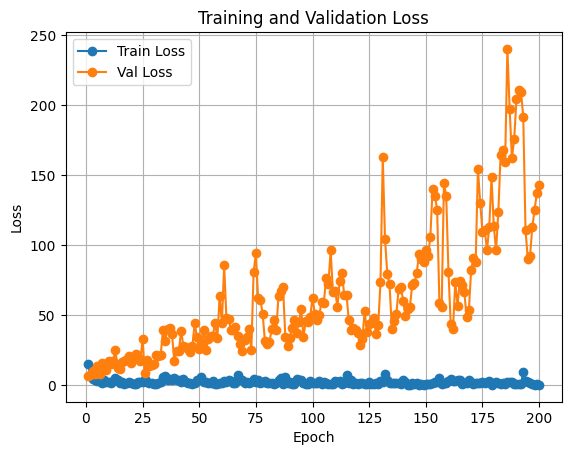

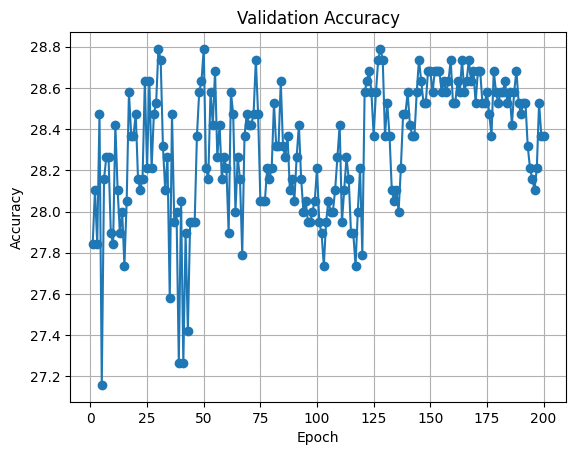

In [ ]:
plot_loss_and_accuracy(json_path='pca_logistic_history.json',
                       save_dir='pca_logistic_history')